# hidden Markov Model tuned to mouse behavior

Tune HMM parameters on training set
Use model to predict mouse decisions given the previous 'n' trial decisions and reward outcomes

In [100]:
import sys
sys.path.append('/Users/shayneufeld/GitHub/mouse_bandit/data_preprocessing_code')
sys.path.append('/Users/shayneufeld/GitHub/mouse_bandit')
import numpy as np
import numpy.random as npr
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
import bandit_preprocessing as bp
import support_functions as sf
%matplotlib inline

## load in 'training' data

I'm going to start with just 1 mouse. 'Harry' has 5 sessions between 07.08.16 and 07.25.16 where he achieved p(choose high port) > 0.85 with 50 reward blocks. Let's use that data: train 3 sessions, and test on 2. 

In [18]:
record = pd.read_csv('/Users/shayneufeld/GitHub/mouse_bandit/session_record.csv',index_col=0)

r_8020 = record[((record['Left Reward Prob'] == 0.8) |  (record['Right Reward Prob'] == 0.2))].copy()
r_8020 = r_8020[r_8020['p(high Port)'] > 0.7].copy()
r_8020 = r_8020[r_8020['No. Blocks'] > 3].copy()
r_8020 = r_8020[r_8020['Block Range Min'] == 50].copy()
#r_8020 = r_8020[r_8020['Mouse ID'] == 'harry'].copy()

r_8020

,Session ID,Mouse ID,Date,Phase,Left Reward Prob,Right Reward Prob,Block Range Min,Block Range Max,No. Trials,No. Blocks,No. Rewards,p(high Port),Decision Window Duration,Min Inter-trial-interval,Left Solenoid Duration,Right Solenoid Duration
59,10142016_q43,q43,10142016,2.0,0.8,0.2,50.0,50.0,651.0,8.0,411.0,0.74,2.0,1.0,35.0,35.0
64,10212016_q43,q43,10212016,2.0,0.8,0.2,50.0,50.0,636.0,8.0,438.0,0.81,2.0,1.0,35.0,35.0
66,11012016_q43,q43,11012016,2.0,0.8,0.2,50.0,50.0,616.0,8.0,409.0,0.78,2.0,1.0,35.0,35.0
68,11032016_q43,q43,11032016,2.0,0.8,0.2,50.0,50.0,635.0,8.0,424.0,0.77,2.0,1.0,35.0,35.0
69,11042016_q43,q43,11042016,2.0,0.8,0.2,50.0,50.0,613.0,8.0,414.0,0.80,2.0,1.0,35.0,35.0
71,11082016_q43,q43,11082016,2.0,0.8,0.2,50.0,50.0,588.0,8.0,402.0,0.80,2.0,1.0,35.0,35.0
84,12012016_q43,q43,12012016,2.0,0.8,0.2,50.0,50.0,566.0,8.0,419.0,0.87,2.0,1.0,35.0,35.0
117,11212016_q45,q45,11212016,2.0,0.8,0.2,50.0,50.0,535.0,7.0,364.0,0.81,2.0,1.0,35.0,35.0
155,10142016_q40,q40,10142016,2.0,0.8,0.2,50.0,50.0,656.0,9.0,467.0,0.81,2.0,1.0,35.0,35.0
159,07222016_dumble,dumble,7222016,2.0,0.8,0.2,50.0,50.0,548.0,7.0,386.0,0.83,2.0,1.0,45.0,40.0


In [19]:
session_names = r_8020['Session ID'].values

'''
load in trial data
'''
columns = ['Elapsed Time (s)','Since last trial (s)','Trial Duration (s)','Port Poked','Right Reward Prob','Left Reward Prob','Reward Given']

root_dir = '/Users/shayneufeld/GitHub/mouse_bandit/data/trial_data'

trial_df = []
n_trials = np.zeros(len(session_names))

for i,session in enumerate(session_names):
    full_name = session + '_trials.csv'
    
    path_name = os.path.join(root_dir,full_name)
    
    trial_df.append(pd.read_csv(path_name,names=columns))
    
    n_trials[i] = trial_df[i].shape[0]

mouse_ids = r_8020['Mouse ID'].values
total_trials = n_trials.sum()

print('Total number of trials in dataset: %.0f' % total_trials)

Total number of trials in dataset: 40791


In [4]:
#transform into feature matrix
for i,df in enumerate(trial_df):
    
    curr_feature_matrix = bp.create_feature_matrix(df,10,mouse_ids[i],session_names[i],feature_names='Default')
    
    if i == 0:
        data = curr_feature_matrix.copy()
    else:
        data = data.append(curr_feature_matrix)

In [101]:
data = pd.read_csv('/Users/shayneufeld/GitHub/mouse_bandit/data/processed_data/full_8020_02192017.csv',index_col=0)

In [102]:
data.shape

(48845, 50)

In [103]:
port_features = []
reward_features = []

    #change right port to -1 instead of 0
for col in data:
    if '_Port' in col:
        port_features.append(col)
    elif '_Reward' in col:
        reward_features.append(col)

In [122]:
'''
Tuned parameters
'''
duration = 60
p = 0.8 # prob of reward if choose the correct side
q = 1.0-p # prob of reward if choose the incorrect side

In [123]:
'''
Set up outcome & transition matrices
'''
#transition matrix
'''
set transition matrix T such that T[i,j] is the probability of transitioning
from state i to state j. 
If the true number of trials before switching is 'duration', then set the
probability of switching to be 1 / duration, and the probability of 
staying to 1 - 1 / duration
'''
s = 1 - 1./duration
T = np.array([[s, 1.0-s],
             [1.0-s,s]])

#observation array
'''
set up array such that O[r,z,a] = Pr(reward=r | state=z,action=a)

eg. when action = L, observation matrix should be:
O[:,:,1]    = [P(r=0 | z=0,a=0),  P(r=0 | z=1,a=0)
               P(r=1 | z=0,a=0),  P(r=1 | z=1,a=0)]
            = [1-p, 1-q
                p,   q]
'''
O = np.zeros((2,2,2))
# let a 'right' choice be represented by '0'
O[:,:,0] = np.array([[1.0-p, 1.0-q],
                     [p,q]])
O[:,:,1] = np.array([[1.0-q, 1.0-p],
                     [q,p]])

#TEST: All conditional probability distributions must sum to one
assert np.allclose(O.sum(0),1), "All conditional probability distributions must sum to one!"

In [125]:
#set test data
data_test = data.copy()

n_trials = data_test.shape[0]

#initialize prediction array
y_predict = np.zeros(n_trials)
likeli = []
master_beliefs = np.zeros(n_trials)

for trial in range(data_test.shape[0]):
    curr_trial = data_test.iloc[trial]
    n_plays = 5
    actions = curr_trial[port_features].values
    rewards = curr_trial[reward_features].values
    beliefs = np.nan*np.ones((n_plays+1,2))
    beliefs[0] = [0.5,0.5] #initialize both sides with equal probability
    #run the algorithm
    for play in range(n_plays):

        assert np.allclose(beliefs[play].sum(), 1.0), "Beliefs must sum to one!"

        #update neg log likelihood
        likeli.append(-1*np.log(beliefs[play,actions[play]]))

        #update beliefs for next play
        #step 1: multiply by p(r_t | z_t = k, a_t)
        belief_temp = O[rewards[play],:,actions[play]] * beliefs[play]

        #step 2: sum over z_t, weighting by transition matrix
        beliefs[play+1] = T.dot(belief_temp)

        #step 3: normalize
        beliefs[play+1] /= beliefs[play+1].sum()

    #predict action
    y_predict[trial] = np.where(beliefs[-1] == beliefs[-1].max())[0][0]
    master_beliefs[trial] = beliefs[-1].max()

/Users/shayneufeld/anaconda/envs/cagrin/lib/python3.5/site-packages/ipykernel/__main__.py:24: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/shayneufeld/anaconda/envs/cagrin/lib/python3.5/site-packages/ipykernel/__main__.py:28: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [119]:
y_test = data_test['Decision'].values
y_test.shape

(48845,)

In [126]:
prev_port_test = data['1_Port'].values

#switches
y_test_switch = np.abs(y_test - prev_port_test)
y_predict_switch = np.abs(y_predict - prev_port_test)
acc_pos,acc_neg,F1=sf.score_both_and_confuse(y_predict_switch,y_test_switch,confusion=False,disp=True)

          Predicted NO  Predicted YES
True NO        36773.0         7188.0
True YES        2648.0         2236.0

F1: 0.313

Accuracy on class 0: 0.84
Accuracy on class 1: 0.46



In [133]:
d = {'beliefs':master_beliefs,'acc':y_predict==y_test}
df = pd.DataFrame(data = d,index=None)

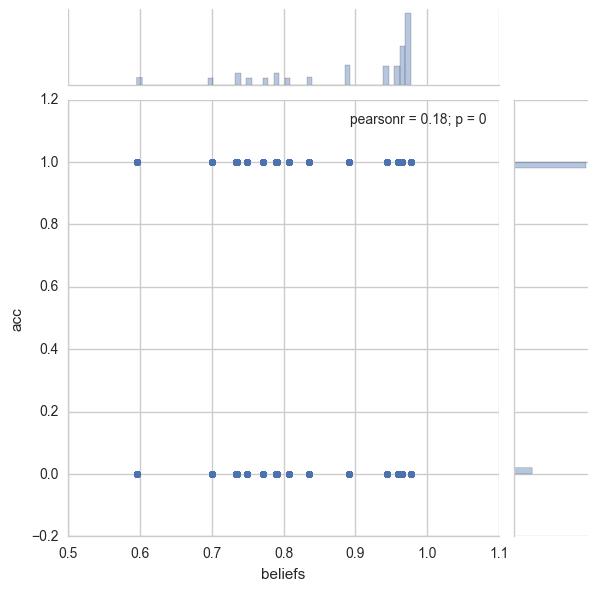

In [134]:
sns.jointplot(x="beliefs", y="acc", data=df);

In [138]:
np.unique(master_beliefs).shape[0]

16

In [137]:
acc_matrix = y_predict == y_test

In [141]:
acc = np.zeros(16)

for j,i in enumerate(np.unique(master_beliefs)):
    indices = np.where(master_beliefs == i)
    acc[j] = acc_matrix[indices].mean()
    

(array([ 0.55,  0.6 ,  0.65,  0.7 ,  0.75,  0.8 ,  0.85,  0.9 ,  0.95]),
 <a list of 9 Text yticklabel objects>)

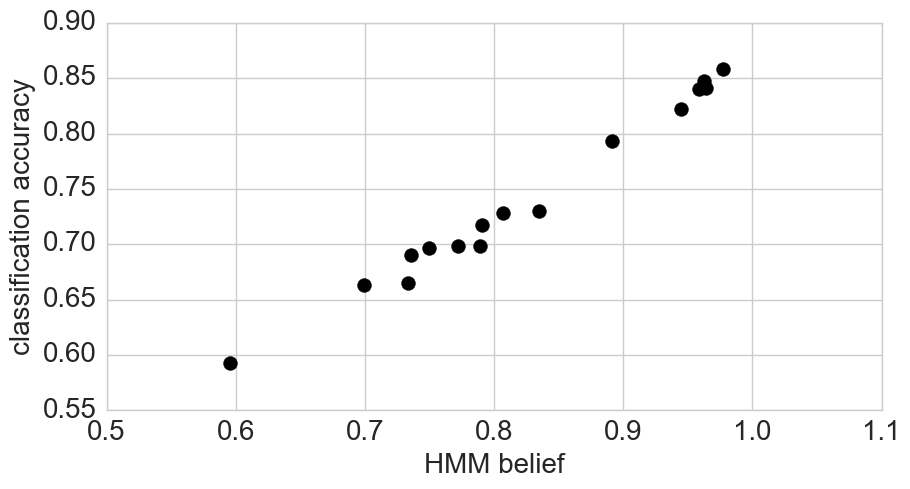

In [147]:
plt.figure(figsize=(10,5))
plt.scatter(np.unique(master_beliefs),acc,color='black',s=100)
plt.xlabel('HMM belief',fontsize=20)
plt.ylabel('classification accuracy',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

In [32]:
model_cols = ['condition','overall','stay','switch']
model_stats = pd.DataFrame(columns=model_cols)

In [66]:
d = {'condition':'70-30','overall':0.80,'stay':0.81,'switch':0.56}
model_stats.append(pd.DataFrame(data=d,index=[2]))

,condition,overall,stay,switch
0,90-10,0.88,0.91,0.59
1,80-20,0.84,0.88,0.53
2,80-20,0.80,0.81,0.56
2,70-30,0.80,0.81,0.56


In [67]:
model_stats = model_stats.append(pd.DataFrame(data=d,index=[2]))

In [68]:
model_stats

,condition,overall,stay,switch
0,90-10,0.88,0.91,0.59
1,80-20,0.84,0.88,0.53
2,80-20,0.80,0.81,0.56
2,70-30,0.80,0.81,0.56


In [73]:
model_stats = model_stats.iloc[[0,1,3]].copy()

In [82]:
d = {'condition':['90-10','90-10','90-10','80-20','80-20','80-20','70-30','70-30','70-30'],
    'accuracy': [0.88,0.91,0.59,0.84,0.88,0.53,0.80,0.81,0.56],
     'type':['overall','stay','switch','overall','stay','switch','overall','stay','switch']
    }

In [166]:
d2 = {'condition':['90-10','80-20','70-30','90-10','80-20','70-30'],
      'model':['HMM','HMM','HMM','logreg','logreg','logreg'],
      'acc':[0.59,0.53,0.56,0.18,0.10,0.05]}

In [85]:
master_stats = pd.DataFrame(data=d,index=None)
master_stats

,accuracy,condition,type
0,0.88,90-10,overall
1,0.91,90-10,stay
2,0.59,90-10,switch
3,0.84,80-20,overall
4,0.88,80-20,stay
5,0.53,80-20,switch
6,0.80,70-30,overall
7,0.81,70-30,stay
8,0.56,70-30,switch


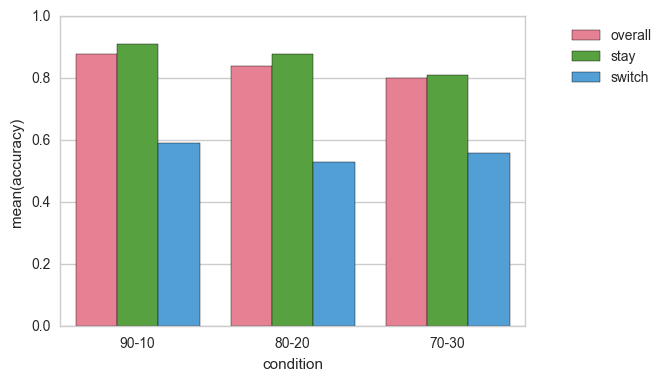

In [96]:
sns.set_style('whitegrid')
sns.barplot(x='condition',y='accuracy',data=master_stats,hue='type',palette='husl')
plt.legend(bbox_to_anchor=(1.3,1))

In [167]:
compare_models = pd.DataFrame(data=d2,index=None)
compare_models

,acc,condition,model
0,0.59,90-10,HMM
1,0.53,80-20,HMM
2,0.56,70-30,HMM
3,0.18,90-10,logreg
4,0.10,80-20,logreg
5,0.05,70-30,logreg


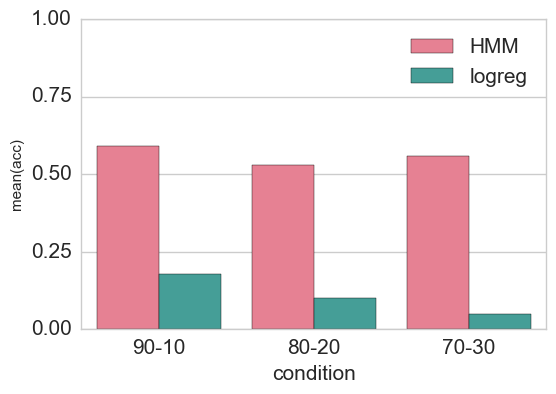

In [173]:
sns.set_style('whitegrid')
sns.barplot(x='condition',y='acc',data=compare_models,hue='model',palette='husl')
plt.legend(bbox_to_anchor=(1.3,1))
plt.ylim(0,1)
plt.yticks([0,0.25,0.5,0.75,1],fontsize=15)
plt.xticks(fontsize=15)
plt.xlabel('condition',fontsize=15)
plt.legend(fontsize=15)

In [163]:
acc = y_predict == y_test

/Users/shayneufeld/anaconda/envs/cagrin/lib/python3.5/site-packages/ipykernel/__main__.py:21: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/shayneufeld/anaconda/envs/cagrin/lib/python3.5/site-packages/ipykernel/__main__.py:22: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/shayneufeld/anaconda/envs/cagrin/lib/python3.5/site-packages/ipykernel/__main__.py:22: RuntimeWarning: divide by zero encountered in double_scalars
/Users/shayneufeld/anaconda/envs/cagrin/lib/python3.5/site-packages/ipykernel/__main__.py:22: RuntimeWarning: invalid value encountered in double_scalars


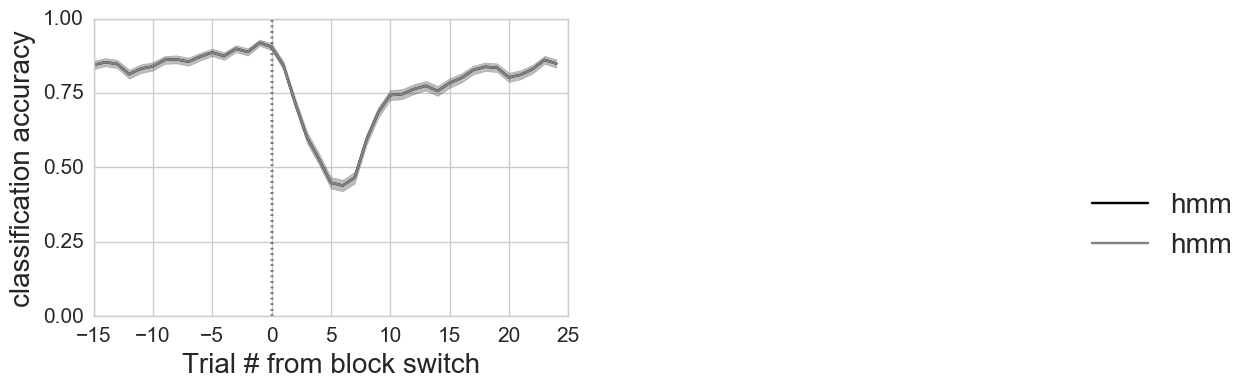

In [165]:
datas = [data,data]
labels = ['hmm','hmm']
colors = ['black','grey','navy']

for c,data in enumerate(datas):

    switches = data['Switch'].values

    t_block_unique = np.unique(data['Block Trial'].values)
    p_switch_block = np.zeros((t_block_unique.shape[0],2))
    high_p_port = np.zeros_like(p_switch_block)
    trial_block_count = np.zeros_like(t_block_unique)

    for t in t_block_unique:
        #p_switch_block[t,0] = data[data['Block Trial'] == t]['Switch'].mean(axis=0)
        #trial_block_count[t] = data[data['Block Trial'] == t].shape[0]
        #p_switch_block[t,1] = data[data['Block Trial'] == t]['Switch'].std(axis=0) / np.sqrt(trial_block_count[t])
        
        curr_trials = data[data['Block Trial']==t].index.values
        
        high_p_port[t,0] = (y_predict[curr_trials]==y_test[curr_trials]).mean(axis=0)
        high_p_port[t,1] = (y_predict[curr_trials]==y_test[curr_trials]).std(axis=0) / np.sqrt(trial_block_count[t])

    data.index = np.arange(data.shape[0]) # <-- this is important
    switch_points = data[data['Block Trial'] == 0].index.values

    L = 15
    paraswitch = np.zeros((switch_points.shape[0],L*2 + 10))
    paraswitch_port = np.zeros_like(paraswitch)

    for i,point in enumerate(switch_points):
        try:
            paraswitch[i,:] = data.iloc[point-L:point+L+10]['Switch']
            paraswitch_port[i,:] = acc[point-L:point+L+10]
        except:
            pass

    u = paraswitch.mean(axis=0)
    s = paraswitch.std(axis=0)
    SE = s/np.sqrt(paraswitch.shape[0])

    #plt.figure(figsize=(15,5))
    #plt.suptitle('analysis of blocks where probabilities switched every 50 rewards',x=0.5,y=1.1,fontsize=20)

    u = paraswitch_port.mean(axis=0)
    s = paraswitch_port.std(axis=0)
    SE = s/np.sqrt(paraswitch.shape[0])
    plt.plot(np.arange(-1*L,L+10),u,color=colors[c],label=labels[c])
    plt.fill_between(np.arange(-1*L,L+10),u+SE,u-SE,color=colors[c],alpha=0.2)
    plt.vlines(x=0,ymin=0,ymax=1,color=colors[c],linestyle='dotted')
    plt.xlabel('Trial # from block switch',fontsize=20)
    plt.ylabel('classification accuracy',fontsize=20)
    #plt.title('probability of choosing high reward port \naround the block switch',fontsize=20,x=0.5,y=1.1)
    plt.xlim(-1*L,L+10)
    plt.xticks(fontsize=15)
    plt.yticks([0,0.25,0.5,0.75,1],fontsize=15)
    plt.ylim(0,1)
    plt.legend(bbox_to_anchor=(2.45,0.5),fontsize=20)

    plt.tight_layout()

In [161]:
(y_predict[curr_trials]==y_test[curr_trials]).mean(axis=0)

0.90498442367601251

In [160]:
a = y_predict[curr_trials]==y_test[curr_trials]
a.mean()

0.90498442367601251